In [1]:
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import csv
from scipy.optimize import fsolve

import sys
import os

folder = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_theory = folder + '/theoretical_curves/'
path_algo = folder + '/algo_perf/'
path_h23 = folder + '/h23_v_ones/d_150/'
path_h3 = folder + '/h3_v_ones/d_150/'
path_h2  = folder + '/h2_v_ones/'
path_relu = folder + '/relu_v_ones/d_150/'
path_elu = folder + '/elu_v_ones/d_150/'


In [2]:
def csv_to_dict(filename):
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        data = {header: [] for header in reader.fieldnames}
        for row in reader:
            for header in reader.fieldnames:
                data[header].append(float(row[header]))
        data = {key: np.array(value) for key, value in data.items()}
    return data

def cplot(ax, activation, color, Delta, gamma, vlaw, label):
    '''
    combine the universal and specialization curve
    '''
    data_uni = csv_to_dict(path_theory + fr'{activation}_Delta_{Delta}_gamma_{gamma}_v_{vlaw}_uni.csv')
    data_spe = csv_to_dict(path_theory + fr'{activation}_Delta_{Delta}_gamma_{gamma}_v_{vlaw}_spe.csv')
    diff = lambda x: np.interp(x, data_uni['alpha'], data_uni['MI']) - np.interp(x, data_spe['alpha'], data_spe['MI'])
    thres = fsolve(diff, 3)
    
    alpha_u, mmse_u = data_uni['alpha'], data_uni['mmse']
    alpha_k, mmse_k = data_spe['alpha'], data_spe['mmse']
    i = np.max(np.where(alpha_u < thres))
    
    # theory = universal + Kabashima
    alphas = np.concatenate((alpha_u[:i+1], alpha_k[i:]))
    mmses = np.concatenate((mmse_u[:i+1], mmse_k[i:]))
    ax.plot(alphas, mmses, color=color, label=label)
    
    # dotted curves
    ax.plot(alpha_u[i:], mmse_u[i:], '--', color=color, linewidth=0.75)
    ax.plot(alpha_k[:i+1], mmse_k[:i+1], ':', color=color, linewidth=1)

def cplot2(ax, activation, color, Delta, gamma, vlaw):
    data_uni = csv_to_dict(path_theory + fr'{activation}_Delta_{Delta}_gamma_{gamma}_v_{vlaw}_uni.csv')
    data_spe = csv_to_dict(path_theory + fr'{activation}_Delta_{Delta}_gamma_{gamma}_v_{vlaw}_spe.csv')
    diff = lambda x: np.interp(x, data_uni['alpha'], data_uni['MI']) - np.interp(x, data_spe['alpha'], data_spe['MI'])
    thres = fsolve(diff, 3)
    
    alpha_u, mmse_u = data_uni['alpha'], data_uni['mmse']
    alpha_k, mmse_k = data_spe['alpha'], data_spe['mmse']
    i = np.max(np.where(alpha_u < thres))

    ax.plot(alpha_k[:i+1], mmse_k[:i+1], '--', color=color, linewidth=1)
    ax.plot(alpha_k[i:], mmse_k[i:], color=color, linewidth=1)
    

In [3]:
gamma = 0.5
Delta = 0.1
vlaw = 'ones'

# theoretical relu and elu curve
activation = 'ReLU'
data_uni_relu = csv_to_dict(path_theory + fr'{activation}_Delta_{Delta}_gamma_{gamma}_v_{vlaw}_uni.csv')

activation = 'ELU'
data_uni_elu = csv_to_dict(path_theory + fr'{activation}_Delta_{Delta}_gamma_{gamma}_v_{vlaw}_uni.csv')

# amp data
relu_data = np.loadtxt(path_algo + 'relu.csv', delimiter=',')
relu_mean = np.mean(relu_data, axis=0)
relu_std  = np.std(relu_data, axis=0)

elu_data = np.loadtxt(path_algo + 'elu.csv', delimiter=',')
elu_mean = np.mean(elu_data, axis=0)
elu_std  = np.std(elu_data, axis=0)

h2_data = np.loadtxt(path_algo + 'h2.csv', delimiter=',')
h2_mean = np.mean(h2_data, axis=0)
h2_std  = np.std(h2_data, axis=0)

h23_data = np.loadtxt(path_algo + 'h23.csv', delimiter=',')
h23_mean = np.mean(h23_data, axis=0)
h23_std  = np.std(h23_data, axis=0)


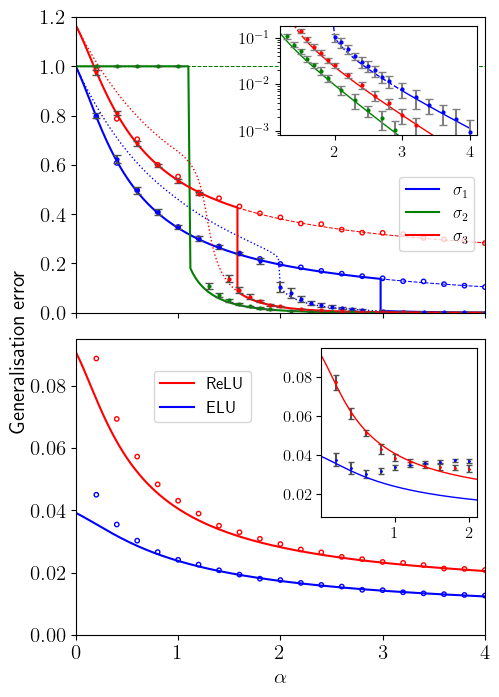

In [4]:
width, height = 5, 7
big, small = int(width*3), int(width*2.4)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(width, height), tight_layout=True)

'''
Upper figure
'''
# theoretical curves
cplot(ax1, activation='Quadratic', color='blue', Delta=1.25, gamma=0.5, vlaw='ones', label=r'$\sigma_1$')
cplot(ax1, activation='Linear + Cubic', color='green', Delta=1.25, gamma=0.5, vlaw='ones', label=r'$\sigma_2$')
cplot(ax1, activation='Quadratic + Cubic', color='red', Delta=1.25, gamma=0.5, vlaw='ones', label=r'$\sigma_3$')

ax1.tick_params(axis='y', labelsize=big, labelbottom=False)
ax1.set_xlim(0, 4)
ax1.set_ylim(0, 1.2)
ax1.legend(loc="lower left", bbox_to_anchor=(0.77, 0.18), fontsize=small)

# MCMC data
result = csv_to_dict(path_h2 + 'result.csv')
remove = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 28, 30, 32, 34, 36, 38] # to many points, keep only some of them
ax1.errorbar(np.delete(result['alpha'], remove), np.delete(result['mean_mmse'], remove), yerr=np.delete(result['std_mmse'], remove), fmt='o', markersize=2, capsize=3, color='blue', ecolor='#505050')

result = csv_to_dict(path_h3 + 'result.csv')
ax1.errorbar(result['alpha'], result['mean_mmse'], yerr=result['std_mmse'], fmt='o', markersize=2, capsize=3, color='green', ecolor='#505050')

result = csv_to_dict(path_h23 + 'result.csv')
ax1.errorbar(result['alpha'], result['mean_mmse'], yerr=result['std_mmse'], fmt='o', markersize=2, capsize=3, color='red', ecolor='#505050')

# AMP data
alphas = np.linspace(0.2, 4, 20)
ax1.scatter(alphas, h2_mean, marker='o', edgecolors='blue', facecolors='none', s=10)
ax1.scatter(alphas, h23_mean, marker='o', edgecolors='red', facecolors='none', s=10)

# Inset figure
inset_ax1 = ax1.inset_axes([0.5, 0.6, 0.48, 0.37]) 

cplot2(inset_ax1, activation='Quadratic + Cubic', color='red', Delta=1.25, gamma=0.5, vlaw='ones')
cplot2(inset_ax1, activation='Linear + Cubic', color='green', Delta=1.25, gamma=0.5, vlaw='ones')
cplot2(inset_ax1, activation='Quadratic', color='blue', Delta=1.25, gamma=0.5, vlaw='ones')

result = csv_to_dict(path_h2 + 'result.csv')
inset_ax1.errorbar(np.delete(result['alpha'], remove), np.delete(result['mean_mmse'], remove), yerr=np.delete(result['std_mmse'], remove), fmt='o', markersize=2, capsize=3, color='blue', ecolor='gray')

result = csv_to_dict(path_h3 + 'result.csv')
inset_ax1.errorbar(result['alpha'], result['mean_mmse'], yerr=result['std_mmse'], fmt='o', markersize=2, capsize=3, color='green', ecolor='gray')

result = csv_to_dict(path_h23 + 'result.csv')
inset_ax1.errorbar(result['alpha'], result['mean_mmse'], yerr=result['std_mmse'], fmt='o', markersize=2, capsize=3, color='red', ecolor='gray')

inset_ax1.tick_params(axis='both', labelsize=small)
inset_ax1.set_xlim(1.2, 4.1)
inset_ax1.set_ylim(0.0008,0.18)
inset_ax1.set_yscale('log')

'''
Lower fig
'''
# theoretical curves
ax2.plot(data_uni_relu['alpha'], data_uni_relu['mmse'], label='ReLU', color='red')
ax2.plot(data_uni_elu['alpha'], data_uni_elu['mmse'], label='ELU', color='blue')

# AMP data
alphas = np.linspace(0.2, 4, 20)
ax2.scatter(alphas, relu_mean, marker='o', edgecolors='red', facecolors='none', s=10)
ax2.scatter(alphas, elu_mean, marker='o', edgecolors='blue', facecolors='none', s=10)

ax2.set_xticks([0,1,2,3,4])
ax2.tick_params(axis='both', labelsize=big)
ax2.set_xlabel(r'$\alpha$', fontsize=big)
ax2.set_xlim(0, 4)
ax2.set_ylim(0, 0.095)
ax2.legend(loc="lower left", bbox_to_anchor=(0.17, 0.69), fontsize=small)


# Inset figure
inset_ax2 = ax2.inset_axes([0.60, 0.40, 0.38, 0.57])  
inset_ax2.set_xlim(0, 2.1)
inset_ax2.set_xticks([1, 2])
inset_ax2.tick_params(axis='both', labelsize=small)


# MCMC data
result = csv_to_dict(path_relu + 'result.csv')
inset_ax2.errorbar(result['alpha'], result['mean_mmse'], yerr=result['std_mmse'], fmt='o', markersize=1, capsize=2, color='red', ecolor='#505050')

result = csv_to_dict(path_elu + 'result.csv')
inset_ax2.errorbar(result['alpha'], result['mean_mmse'], yerr=result['std_mmse'], fmt='o', markersize=1, capsize=2, color='blue', ecolor='#505050')

inset_ax2.plot(data_uni_relu['alpha'], data_uni_relu['mmse'], color='red', linewidth = 1)
inset_ax2.plot(data_uni_elu['alpha'], data_uni_elu['mmse'], color='blue', linewidth = 1)

fig.tight_layout(rect=[0.02, 0, 1, 1])
fig.text(0.01, 0.5, "Generalisation error", fontsize=big, va='center', rotation='vertical')

plt.savefig('fig.pdf')